# S. Venturi - UQ Analysis of a Mass-Spring-Damper System
## Adapted from T. Oliver et al. - Validating Predicitons of Unobserved Quantities - 2014 (https://arxiv.org/abs/1404.7555)
## Case 3 (Slide Nb 21 of the Presentation, Part I): 

### In this example, the physical model of the mass-spring-damper systems follows the equation $m \ddot{x} + c \dot{x} + k x = 0$, with $m$  and $k$ equal to some constants, AND $c$ depending on the temperature, which increases with the physical body's velocity. 
### The computational model is formulated through $m \ddot{x} + c \dot{x} + k x = 0$. However, two of the three coefficients ($m$ and $k$) are treated as constants, with $k$ unknown and to be reconstructed from limited observations (i.e., from noisy position data sampled at discrete time steps). Moreover, $c$ is modeled as a Gaussian distribution, the mean and standard deviation of which must be reconstructed together with $k$.
### What is the amount of uncertainty that we should expect on the predicted QoIs (e.g., position and velocity)?
### How does this compare to the uncertainty from Case 1 and 2?
### How does this depend on the magnitude of the observational error?
### Can we reconstruct the observational error?

###################################################################################################################
### Note: numpy, scipy, matplotlib, theano, pymc3 libraries are required. In order to install them, type from the terminal: pip3 install library-name. 

### Import Libraries

In [1]:
from scipy.integrate import ode
import numpy
import matplotlib.pyplot as plt
import theano
import theano.tensor as tt
from theano.compile.ops import as_op
import pymc3 as pm

### Defining Simulation Parameters (Inital Conditions and Physical Coefficients)

In [2]:
y0     = [4.0, 0.0, 20.0]
t0     = 0.0
tEnd   = 8.0
dt     = 1.0
dtData = 0.01
t      = numpy.linspace(t0, tEnd, int(tEnd)+1)

### Defining Ideal Model:     
### $m \ddot{x} + c \dot{x} + k x = 0$,    
### with 
### $\begin{cases}
      m=1.0\\
      c=c(T) = \exp \biggl( \frac{T_0}{T} - 1 \biggr), ~ ~ ~ \text{and}  ~ ~ ~ \dot{T} = c(T) \dot{x}^2 - \frac{T-T_0}{t_T} \\
      t_T = 1.0 \\
      k=3.0
    \end{cases}$
### $\begin{cases}
    x(0)=4.0 \\
    \dot{x}(0) = 0.0 \\
    T(0) = T_0 = 20.0
    \end{cases}$
### and Sampling Clean Data Points
    

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


Original Data Points =  [4.0, 0.4025660389989435, -1.9135556475509645, 0.07536164513932006, 0.8219707327268324, -0.12599939119617984, -0.3076159087148105, 0.08109328243742872, 0.10624925667502882]


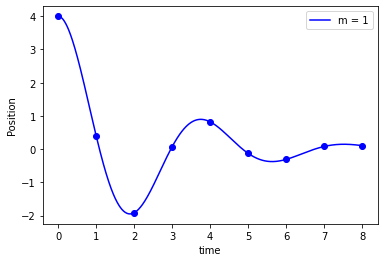

In [3]:
mOrig1 = 1.0
mOrig2 = 3.0
kOrig  = 3.0
Tt     = 1.0

# Truth System ( ~ High Fidelity Model + Noise )

def fOrig(t, y, arg1):
    return [y[1], -arg1[0]/arg1[2]*y[0] -numpy.exp(arg1[3]/y[2]-1.0)/arg1[2]*y[1], numpy.exp(arg1[3]/y[2]-1.0)*y[1]**2 - (y[2]-arg1[3])/arg1[4] ]

def jacOrig(t, y, arg1):
    return [ [0.0, 1.0, 0.0], [-arg1[0]/arg1[2], -numpy.exp(arg1[3]/y[2]-1.0)/arg1[2], y[1]/arg1[2]*(arg1[3]*numpy.exp(arg1[3]/y[2]-1.0)/y[2]**2)], [0.0, 2.0*numpy.exp(arg1[3]/y[2]-1.0), y[1]**2*numpy.exp(arg1[3]/y[2]-1.0)*arg1[3]/y[2]**2 - 1.0/arg1[4]] ]

# For Mass = 1
rOrig1 = ode(fOrig, jacOrig).set_integrator('vode', method='Adams', with_jacobian=True, atol=1.e-20)
rOrig1.set_initial_value(y0, t0).set_f_params([kOrig, 0.0, mOrig1, y0[2], Tt]).set_jac_params([kOrig, 0.0, mOrig1, y0[2], Tt])
tDataPlot = []
xDataPlot = []
vDataPlot = []
tDataPlot.append(t0)
xDataPlot.append(y0[0])
vDataPlot.append(y0[1])
while rOrig1.successful() and rOrig1.t <= tEnd:
    rOrig1.integrate(rOrig1.t+dtData)
    tDataPlot.append(rOrig1.t)
    xDataPlot.append(numpy.real(rOrig1.y[0]))
    vDataPlot.append(numpy.real(rOrig1.y[1]))

## For Mass = 2
#rOrig2 = ode(fOrig, jacOrig).set_integrator('vode', method='Adams', with_jacobian=True, atol=1.e-20)
#rOrig2.set_initial_value(y0, t0).set_f_params([kOrig, 0.0, mOrig2, y0[2], Tt]).set_jac_params([kOrig, 0.0, mOrig2, y0[2], Tt])
#tDataPlot.append(t0)
#xDataPlot.append(y0[0])
#vDataPlot.append(y0[1])
#while rOrig2.successful() and rOrig2.t <= tEnd:
#    rOrig2.integrate(rOrig2.t+dtData)
#    tDataPlot.append(rOrig2.t)
#    xDataPlot.append(numpy.real(rOrig2.y[0]))
#    vDataPlot.append(numpy.real(rOrig2.y[1]))


# For Mass = 1
rOrig1 = ode(fOrig, jacOrig).set_integrator('vode', method='Adams', with_jacobian=True, atol=1.e-20)
rOrig1.set_initial_value(y0, t0).set_f_params([kOrig, 0.0, mOrig1, y0[2], Tt]).set_jac_params([kOrig, 0.0, mOrig1, y0[2], Tt])
tData = []
xData = []
vData = []
tData.append(t0)
xData.append(y0[0])
vData.append(y0[1])
while rOrig1.successful() and rOrig1.t < tEnd:
    rOrig1.integrate(rOrig1.t+dt)
    tData.append(rOrig1.t)
    xData.append(numpy.real(rOrig1.y[0]))
    vData.append(numpy.real(rOrig1.y[1]))

## For Mass = 2
#rOrig2 = ode(fOrig, jacOrig).set_integrator('vode', method='Adams', with_jacobian=True, atol=1.e-20)
#rOrig2.set_initial_value(y0, t0).set_f_params([kOrig, 0.0, mOrig2, y0[2], Tt]).set_jac_params([kOrig, 0.0, mOrig2, y0[2], Tt])
#while rOrig2.successful() and rOrig2.t < tEnd:
#    rOrig2.integrate(rOrig2.t+dt)
#    tData.append(rOrig2.t)
#    xData.append(numpy.real(rOrig2.y[0]))
#    vData.append(numpy.real(rOrig2.y[1]))

#xData = numpy.array([4.0, 4.056287e-1, -1.917800, 7.331597e-2, 8.176825e-1, -1.129453e-1, -3.011407e-1, 9.303637e-2, 8.884368e-2])#, ...
##                     1.705548, -1.634634, -2.127946, -12.8128642e-1, 1.269814, 8.507498e-1, -3.259694e-1, -7.080865e-1])
#HalfLength     = int(numpy.size(tData)/2)
#HalfLengthPlot = int(numpy.size(tDataPlot)/2)

print('Original Data Points = ', xData)
line1, = plt.plot(tDataPlot, xDataPlot,'b')
#line1, = plt.plot(tDataPlot[0:HalfLengthPlot-1],xDataPlot[0:HalfLengthPlot-1],'b')
line1.set_label('m = 1')
plt.plot(tData,xData,'bo')
#plt.plot(tData[0:HalfLength-1],xData[0:HalfLength-1],'bo')
#line2, = plt.plot(tDataPlot[HalfLengthPlot:-1],xDataPlot[HalfLengthPlot:-1],'g')
#line2.set_label('m = 2')
#plt.plot(tData[HalfLength:-1],xData[HalfLength:-1],'go')
plt.xlabel('time')
plt.ylabel('Position')
plt.legend()
plt.savefig('Case3_Data', format='eps')
plt.show()


### Defining Ideal Model with Noise:    
### $m \ddot{x} + c \dot{x} + k x = 0$,    
### with 
### $\begin{cases}
      m=1.0\\
      c=c(T) = \exp \biggl( \frac{T_0}{T} - 1 \biggr), ~ ~ ~ \text{and}  ~ ~ ~ \dot{T} = c(T) \dot{x}^2 - \frac{T-T_0}{t_T} \\
      t_T = 1.0 \\
      k=3.0
    \end{cases}$
### $\begin{cases}
    x(0)=4.0 \\
    \dot{x}(0) = 0.0 \\
    T(0) = T_0 = 20.0
    \end{cases}$
    
### and Additive Noise: 
### $\epsilon \sim \mathcal{N}(0, \sigma_N^2 = 0.1^2)$;
### Sampling Noisy Data Points

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


Noisy Data Points =  [4.0, 0.36109746105011825, -1.9691836833247012, -0.14627030564902627, 0.7540571872690238, -0.1350013991512631, -0.2290117245842072, -0.04678133636301568, -0.0004032984516164906]


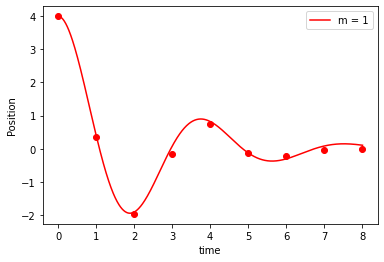

In [4]:
mOrig1 = 1.0
mOrig2 = 3.0
kOrig  = 3.0
Tt     = 1.0
SigmaN = 0.1

# Truth System ( ~ High Fidelity Model + Noise )

def fOrig(t, y, arg1):
    return [y[1], -arg1[0]/arg1[2]*y[0] -numpy.exp(arg1[3]/y[2]-1.0)/arg1[2]*y[1], numpy.exp(arg1[3]/y[2]-1.0)*y[1]**2 - (y[2]-arg1[3])/arg1[4] ]

def jacOrig(t, y, arg1):
    return [ [0.0, 1.0, 0.0], [-arg1[0]/arg1[2], -numpy.exp(arg1[3]/y[2]-1.0)/arg1[2], y[1]/arg1[2]*(arg1[3]*numpy.exp(arg1[3]/y[2]-1.0)/y[2]**2)], [0.0, 2.0*numpy.exp(arg1[3]/y[2]-1.0), y[1]**2*numpy.exp(arg1[3]/y[2]-1.0)*arg1[3]/y[2]**2 - 1.0/arg1[4]] ]

# For Mass = 1
rOrig1 = ode(fOrig, jacOrig).set_integrator('vode', method='Adams', with_jacobian=True, atol=1.e-20)
rOrig1.set_initial_value(y0, t0).set_f_params([kOrig, 0.0, mOrig1, y0[2], Tt]).set_jac_params([kOrig, 0.0, mOrig1, y0[2], Tt])
tDataNoisePlot = []
xDataNoisePlot = []
vDataNoisePlot = []
tDataNoisePlot.append(t0)
xDataNoisePlot.append(y0[0])
vDataNoisePlot.append(y0[1])
while rOrig1.successful() and rOrig1.t <= tEnd:
    rOrig1.integrate(rOrig1.t+dtData)
    tDataNoisePlot.append(rOrig1.t)
    xDataNoisePlot.append(numpy.real(rOrig1.y[0]))
    vDataNoisePlot.append(numpy.real(rOrig1.y[1]))

## For Mass = 2
#rOrig2 = ode(fOrig, jacOrig).set_integrator('vode', method='Adams', with_jacobian=True, atol=1.e-20)
#rOrig2.set_initial_value(y0, t0).set_f_params([kOrig, 0.0, mOrig2, y0[2], Tt]).set_jac_params([kOrig, 0.0, mOrig2, y0[2], Tt])
#tDataNoisePlot.append(t0)
#xDataNoisePlot.append(y0[0])
#vDataNoisePlot.append(y0[1])
#while rOrig2.successful() and rOrig2.t <= tEnd:
#    rOrig2.integrate(rOrig2.t+dtData)
#    tDataNoisePlot.append(rOrig2.t)
#    xDataNoisePlot.append(numpy.real(rOrig2.y[0]))
#    vDataNoisePlot.append(numpy.real(rOrig2.y[1]))


# For Mass = 1
rOrig1 = ode(fOrig, jacOrig).set_integrator('vode', method='Adams', with_jacobian=True, atol=1.e-20)
rOrig1.set_initial_value(y0, t0).set_f_params([kOrig, 0.0, mOrig1, y0[2], Tt]).set_jac_params([kOrig, 0.0, mOrig1, y0[2], Tt])
tDataNoise = []
xDataNoise = []
vDataNoise = []
tDataNoise.append(t0)
xDataNoise.append(y0[0])
vDataNoise.append(y0[1])
while rOrig1.successful() and rOrig1.t < tEnd:
    rOrig1.integrate(rOrig1.t+dt)
    tDataNoise.append(rOrig1.t)
    xDataNoise.append(numpy.real(rOrig1.y[0]))
    vDataNoise.append(numpy.real(rOrig1.y[1]))

xNoise         = numpy.random.normal(0.0, SigmaN, 8)
xDataNoise[1:] = xDataNoise[1:] + xNoise

## For Mass = 2
#rOrig2 = ode(fOrig, jacOrig).set_integrator('vode', method='Adams', with_jacobian=True, atol=1.e-20)
#rOrig2.set_initial_value(y0, t0).set_f_params([kOrig, 0.0, mOrig2, y0[2], Tt]).set_jac_params([kOrig, 0.0, mOrig2, y0[2], Tt])
#while rOrig2.successful() and rOrig2.t < tEnd:
#    rOrig2.integrate(rOrig2.t+dt)
#    tDataNoise.append(rOrig2.t)
#    xDataNoise.append(numpy.real(rOrig2.y[0]))
#    vDataNoise.append(numpy.real(rOrig2.y[1]))

#xDataNoise = numpy.array([4.0, 4.056287e-1, -1.917800, 7.331597e-2, 8.176825e-1, -1.129453e-1, -3.011407e-1, 9.303637e-2, 8.884368e-2])#, ...
##                     1.705548, -1.634634, -2.127946, -12.8128642e-1, 1.269814, 8.507498e-1, -3.259694e-1, -7.080865e-1])
#HalfLength     = int(numpy.size(tDataNoise)/2)
#HalfLengthPlot = int(numpy.size(tDataNoisePlot)/2)

print('Noisy Data Points = ', xDataNoise)
line1, = plt.plot(tDataNoisePlot, xDataNoisePlot,'r')
#line1, = plt.plot(tDataPlot[0:HalfLengthPlot-1],xDataPlot[0:HalfLengthPlot-1],'b')
line1.set_label('m = 1')
plt.plot(tDataNoise,xDataNoise,'ro')
#plt.plot(tData[0:HalfLength-1],xData[0:HalfLength-1],'bo')
#line2, = plt.plot(tDataPlot[HalfLengthPlot:-1],xDataPlot[HalfLengthPlot:-1],'g')
#line2.set_label('m = 2')
#plt.plot(tData[HalfLength:-1],xData[HalfLength:-1],'go')
plt.xlabel('time')
plt.ylabel('Position')
plt.legend()
plt.savefig('Case3_NoisyData', format='eps')
plt.show()

### Defining Computational Model: (i.e., Some Missing Physics Represented through Uncertain Coefficients AND Hyperparameters):
### $m \ddot{x} + c \dot{x} + k x = 0$,    with 
### $\begin{cases}
      m=1.0\\
      c= \mathcal{N}(\mu_{c}, \sigma_{c}^2)\\
      \mu_{c}=? \\
      \sigma_{c}=?\\
      k= ?\\
    \end{cases}$
### $\begin{cases}
    x(0)=4.0 \\
    \dot{x}(0) = 0.0 \\
    \end{cases}$
    
### Additive Noise: $\epsilon \sim \mathcal{N}(0, \sigma_L^2)$

In [5]:
# Model Form
@as_op(itypes=[tt.dscalar, tt.dscalar], otypes=[tt.dvector])
def th_forward_model(param1, param2):
    y0, t0 = [4.0, 0.0], 0.0
    tEnd   = 8.0
    dt     = 1.0
    def f(t, y, arg1):
        return [y[1], -arg1[0]/arg1[2]*y[0]-arg1[1]/arg1[2]*y[1]]
    def jac(t, y, arg1):
        return [[0.0, 1.0], [-arg1[0]/arg1[2], -arg1[1]/arg1[2]]]
    tPred = []
    xPred = []
    vPred = []
    tPred.append(t0)
    xPred.append(y0[0])
    vPred.append(y0[1])
    r1 = ode(f, jac).set_integrator('vode', method='Adams', with_jacobian=True, atol=1.e-20)
    r1.set_initial_value(y0, t0).set_f_params([param1, param2, 1.0]).set_jac_params([param1, param2, 1.0])
    while r1.successful() and r1.t < tEnd:
        r1.integrate(r1.t+dt)
        tPred.append(r1.t)
        xPred.append(numpy.real(r1.y[0]))
        vPred.append(numpy.real(r1.y[1]))
    #r2 = ode(f, jac).set_integrator('vode', method='Adams', with_jacobian=True, atol=1.e-20)
    #r2.set_initial_value(y0, t0).set_f_params([param1, param2, 2.0]).set_jac_params([param1, param2, 2.0])
    #while r2.successful() and r2.t < tEnd:
    #    r2.integrate(r2.t+dt)
    #    tPred.append(r2.t)
    #    xPred.append(numpy.real(r2.y[0]))
    #    vPred.append(numpy.real(r2.y[1]))
    xPred = numpy.array(xPred)
    th_states = xPred
    return th_states

##############################################################################################################
### Case 3.1: Reconstructing $k$ and $c$ from the Clean Data
### Note: $\sigma_L$ is fixed to $\sigma_L = 0.01$

In [6]:
### Model 1
Model1 = pm.Model()

# Model Construction
with Model1:
    K1     = pm.Normal('K1',    1.0, numpy.sqrt(0.5))
    c1mu   = pm.Normal('c1mu',        0.0, numpy.sqrt(0.5))
    c1sigma= pm.Lognormal('c1sigma', -1.0, numpy.sqrt(0.4))
    c1     = pm.Lognormal('c1',      c1mu, c1sigma) 
    xPred1 = th_forward_model(K1, c1)
    x1At0  = pm.Deterministic('x1@0',xPred1[0])
    x1At1  = pm.Deterministic('x1@1',xPred1[1])
    x1At2  = pm.Deterministic('x1@2',xPred1[2])
    x1At3  = pm.Deterministic('x1@3',xPred1[3])
    x1At4  = pm.Deterministic('x1@4',xPred1[4])
    x1At5  = pm.Deterministic('x1@5',xPred1[5])
    x1At6  = pm.Deterministic('x1@6',xPred1[6])
    x1At7  = pm.Deterministic('x1@7',xPred1[7])
    x1At8  = pm.Deterministic('x1@8',xPred1[8])
    Sigma1 = 1.e-2
    yLike1 = pm.Normal('yLike1', mu=xPred1, sd=Sigma1, observed=xData)

# Model Calibration with Perfect Data
with Model1:
    trace1 = pm.sample(5000, step=pm.Metropolis(), tune=1000, cores=1)


/usr/local/lib/python3.8/site-packages/pymc3/sampling.py:465: FutureWarning: In an upcoming release, pm.sample will return an `arviz.InferenceData` object instead of a `MultiTrace` by default. You can pass return_inferencedata=True or return_inferencedata=False to be safe and silence this warning.
  warnings.warn(
Sequential sampling (2 chains in 1 job)
CompoundStep
>Metropolis: [c1]
>Metropolis: [c1sigma]
>Metropolis: [c1mu]
>Metropolis: [K1]


Sampling 2 chains for 1_000 tune and 5_000 draw iterations (2_000 + 10_000 draws total) took 101 seconds.
The rhat statistic is larger than 1.05 for some parameters. This indicates slight problems during sampling.
The estimated number of effective samples is smaller than 200 for some parameters.


/usr/local/lib/python3.8/site-packages/pymc3/plots/__init__.py:35: UserWarning: Keyword argument `varnames` renamed to `var_names`, and will be removed in pymc3 3.8
  warnings.warn(
/usr/local/lib/python3.8/site-packages/arviz/plots/backends/matplotlib/traceplot.py:150: UserWarning: A valid var_name should be provided, found {'K'} expected from {'K1', 'c1'}
  warnings.warn(
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


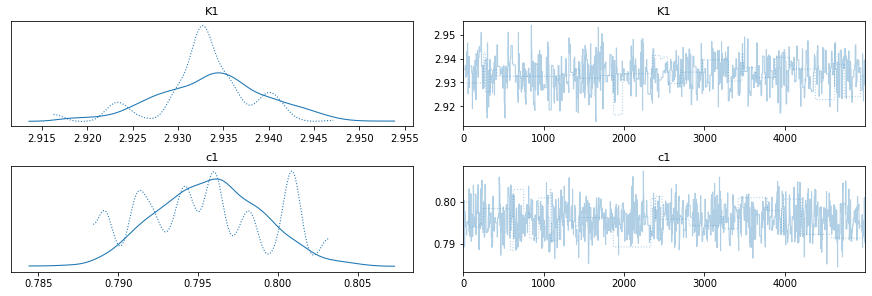

In [7]:
# Plot Parameter Posterior Distributions
with Model1:
    trarr = pm.traceplot(trace1, varnames=['K1','c1'], lines={'K1':3.0} );
    plt.savefig('Case3_Model1_ParamsPosts', format='eps')
    plt.show()

In [8]:
# Print Statistics
with Model1:
    print(pm.summary(trace1))

          mean     sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  ess_mean   ess_sd  \
K1       2.933  0.006   2.923    2.943      0.000    0.000     159.0    159.0   
c1mu    -0.168  0.349  -0.864    0.519      0.007    0.006    2252.0   1573.0   
c1sigma  0.402  0.251   0.047    0.844      0.007    0.005    1471.0   1471.0   
c1       0.796  0.004   0.789    0.801      0.000    0.000      66.0     66.0   
x1@0     4.000  0.000   4.000    4.000      0.000    0.000   10000.0  10000.0   
x1@1     0.384  0.005   0.375    0.393      0.000    0.000     170.0    170.0   
x1@2    -1.854  0.006  -1.866   -1.844      0.001    0.001      66.0     66.0   
x1@3     0.063  0.006   0.052    0.074      0.000    0.000     179.0    179.0   
x1@4     0.829  0.006   0.819    0.839      0.001    0.001      65.0     65.0   
x1@5    -0.134  0.005  -0.143   -0.126      0.000    0.000     174.0    173.0   
x1@6    -0.357  0.004  -0.363   -0.350      0.000    0.000      66.0     66.0   
x1@7     0.106  0.003   0.10

/usr/local/lib/python3.8/site-packages/pymc3/plots/__init__.py:35: UserWarning: Keyword argument `varnames` renamed to `var_names`, and will be removed in pymc3 3.8
  warnings.warn(
/usr/local/lib/python3.8/site-packages/arviz/plots/backends/matplotlib/traceplot.py:150: UserWarning: A valid var_name should be provided, found {'x'} expected from {'x1@5', 'x1@1', 'x1@3', 'x1@6', 'x1@2', 'x1@8', 'x1@4', 'x1@7'}
  warnings.warn(
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend doe

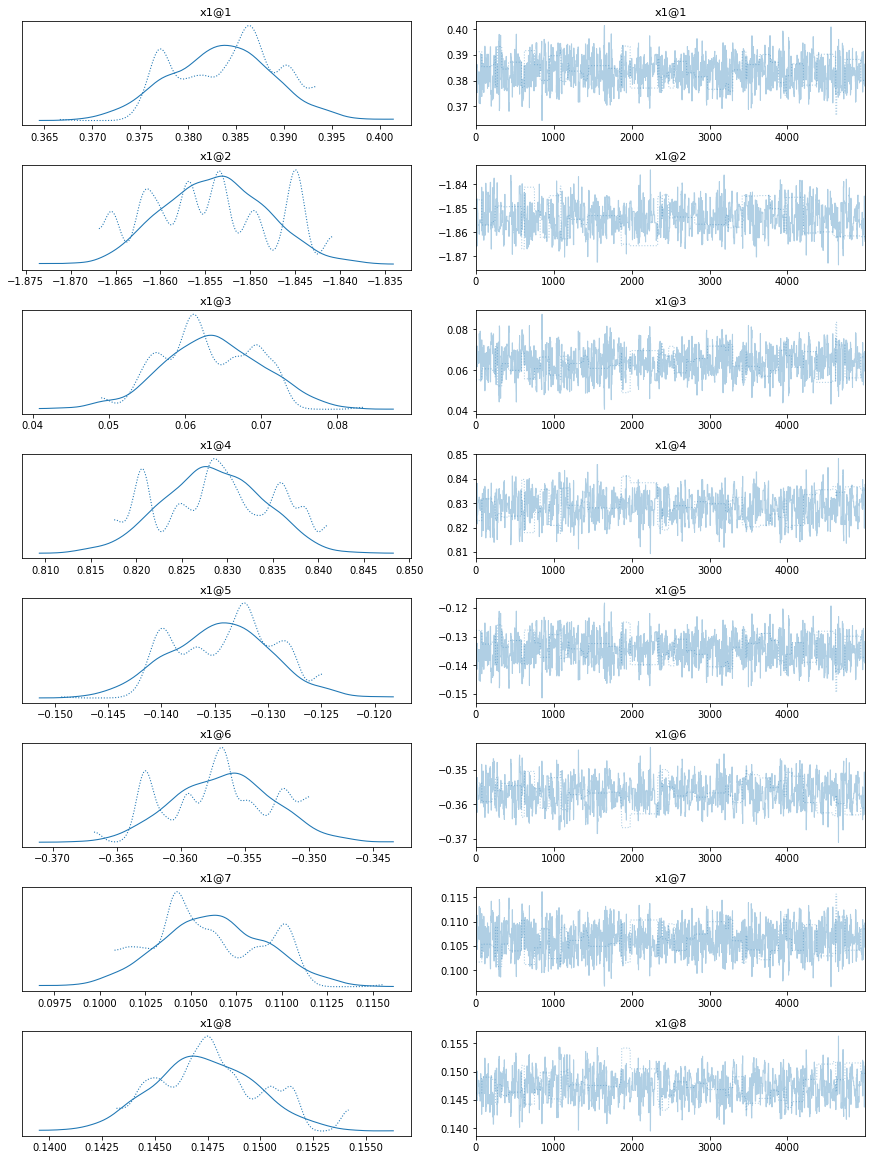

In [9]:
# Plot Output Posterior Distributions
with Model1:
    trarr = pm.traceplot(trace1, varnames=['x1@1','x1@2','x1@3','x1@4', 'x1@5','x1@6','x1@7','x1@8'], 
                  lines={'x1@1': xData[1], 'x1@2': xData[2], 'x1@3': xData[3], 'x1@4': xData[4], 'x1@5': xData[5], 'x1@6': xData[6], 'x1@7': xData[7], 'x1@8': xData[8]} );
    plt.savefig('Case3_Model1_OutputPosts', format='eps')
    plt.show()

##############################################################################################################
### Case 3.2: Reconstructing $k$ and $c$ from the Clean Data
### Note: $\sigma_L$ gets Calibrated as well

In [10]:
# Model 2
Model2 = pm.Model()

# Model Construction
with Model2:
    K2     = pm.Normal('K2',    1.0, numpy.sqrt(0.5))
    c2mu   = pm.Normal('c2mu',        0.0, numpy.sqrt(0.5))
    c2sigma= pm.Lognormal('c2sigma', -1.0, numpy.sqrt(0.4))
    c2     = pm.Lognormal('c2',      c2mu, c2sigma) 
    xPred2 = th_forward_model(K2, c2)
    x2At0  = pm.Deterministic('x2@0',xPred2[0])
    x2At1  = pm.Deterministic('x2@1',xPred2[1])
    x2At2  = pm.Deterministic('x2@2',xPred2[2])
    x2At3  = pm.Deterministic('x2@3',xPred2[3])
    x2At4  = pm.Deterministic('x2@4',xPred2[4])
    x2At5  = pm.Deterministic('x2@5',xPred2[5])
    x2At6  = pm.Deterministic('x2@6',xPred2[6])
    x2At7  = pm.Deterministic('x2@7',xPred2[7])
    x2At8  = pm.Deterministic('x2@8',xPred2[8])
    Sigma2 = pm.Lognormal('Sigma2', 0.0, 1.0)
    yLike2 = pm.Normal('yLike2', mu=xPred2, sd=Sigma2, observed=xData)

# Model Calibration with Perfect Data
with Model2:
    trace2 = pm.sample(5000, step=pm.Metropolis(), tune=1000, cores=1)

/usr/local/lib/python3.8/site-packages/pymc3/sampling.py:465: FutureWarning: In an upcoming release, pm.sample will return an `arviz.InferenceData` object instead of a `MultiTrace` by default. You can pass return_inferencedata=True or return_inferencedata=False to be safe and silence this warning.
  warnings.warn(
Sequential sampling (2 chains in 1 job)
CompoundStep
>Metropolis: [Sigma2]
>Metropolis: [c2]
>Metropolis: [c2sigma]
>Metropolis: [c2mu]
>Metropolis: [K2]


Sampling 2 chains for 1_000 tune and 5_000 draw iterations (2_000 + 10_000 draws total) took 174 seconds.
The number of effective samples is smaller than 10% for some parameters.


/usr/local/lib/python3.8/site-packages/pymc3/plots/__init__.py:35: UserWarning: Keyword argument `varnames` renamed to `var_names`, and will be removed in pymc3 3.8
  warnings.warn(
/usr/local/lib/python3.8/site-packages/arviz/plots/backends/matplotlib/traceplot.py:150: UserWarning: A valid var_name should be provided, found {'K'} expected from {'c2', 'Sigma2', 'K2'}
  warnings.warn(
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially tran

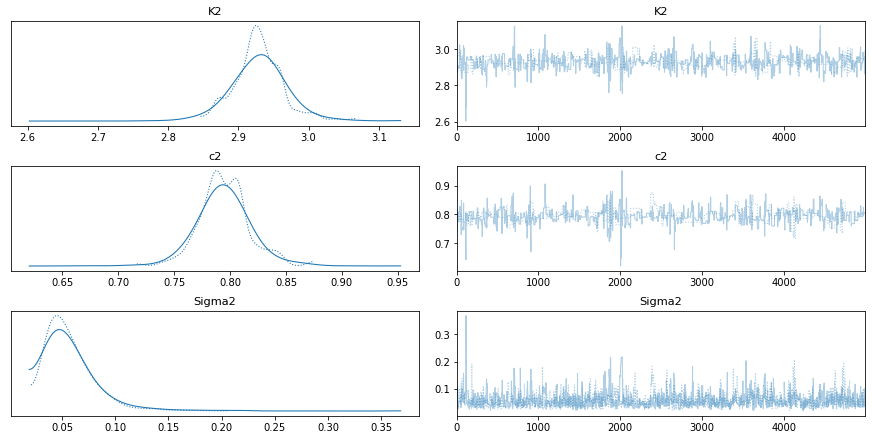

In [11]:
# Plot Parameter Posterior Distributions
with Model2:
    trarr = pm.traceplot(trace2, varnames=['K2','c2', 'Sigma2'], lines={'K2': 3.0} );
    plt.savefig('Case3_Model2_ParamPosts', format='eps')
    plt.show()

In [12]:
# Print Statistics
with Model2:
    print(pm.summary(trace2))

          mean     sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  ess_mean   ess_sd  \
K2       2.930  0.037   2.860    2.997      0.002    0.001     371.0    371.0   
c2mu    -0.167  0.341  -0.840    0.482      0.008    0.006    2031.0   1848.0   
c2sigma  0.395  0.254   0.055    0.836      0.007    0.005    1401.0   1401.0   
c2       0.795  0.023   0.759    0.846      0.001    0.001     357.0    357.0   
x2@0     4.000  0.000   4.000    4.000      0.000    0.000   10000.0  10000.0   
x2@1     0.387  0.033   0.322    0.445      0.001    0.001     615.0    604.0   
x2@2    -1.855  0.041  -1.919   -1.769      0.002    0.002     363.0    363.0   
x2@3     0.059  0.040  -0.017    0.131      0.002    0.001     541.0    541.0   
x2@4     0.831  0.038   0.756    0.900      0.002    0.001     328.0    328.0   
x2@5    -0.132  0.029  -0.189   -0.080      0.001    0.001     602.0    602.0   
x2@6    -0.359  0.026  -0.414   -0.314      0.001    0.001     308.0    308.0   
x2@7     0.105  0.018   0.07

/usr/local/lib/python3.8/site-packages/pymc3/plots/__init__.py:35: UserWarning: Keyword argument `varnames` renamed to `var_names`, and will be removed in pymc3 3.8
  warnings.warn(
/usr/local/lib/python3.8/site-packages/arviz/plots/backends/matplotlib/traceplot.py:150: UserWarning: A valid var_name should be provided, found {'x'} expected from {'x2@1', 'x2@2', 'x2@8', 'x2@4', 'x2@5', 'x2@7', 'x2@6', 'x2@3'}
  warnings.warn(
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend doe

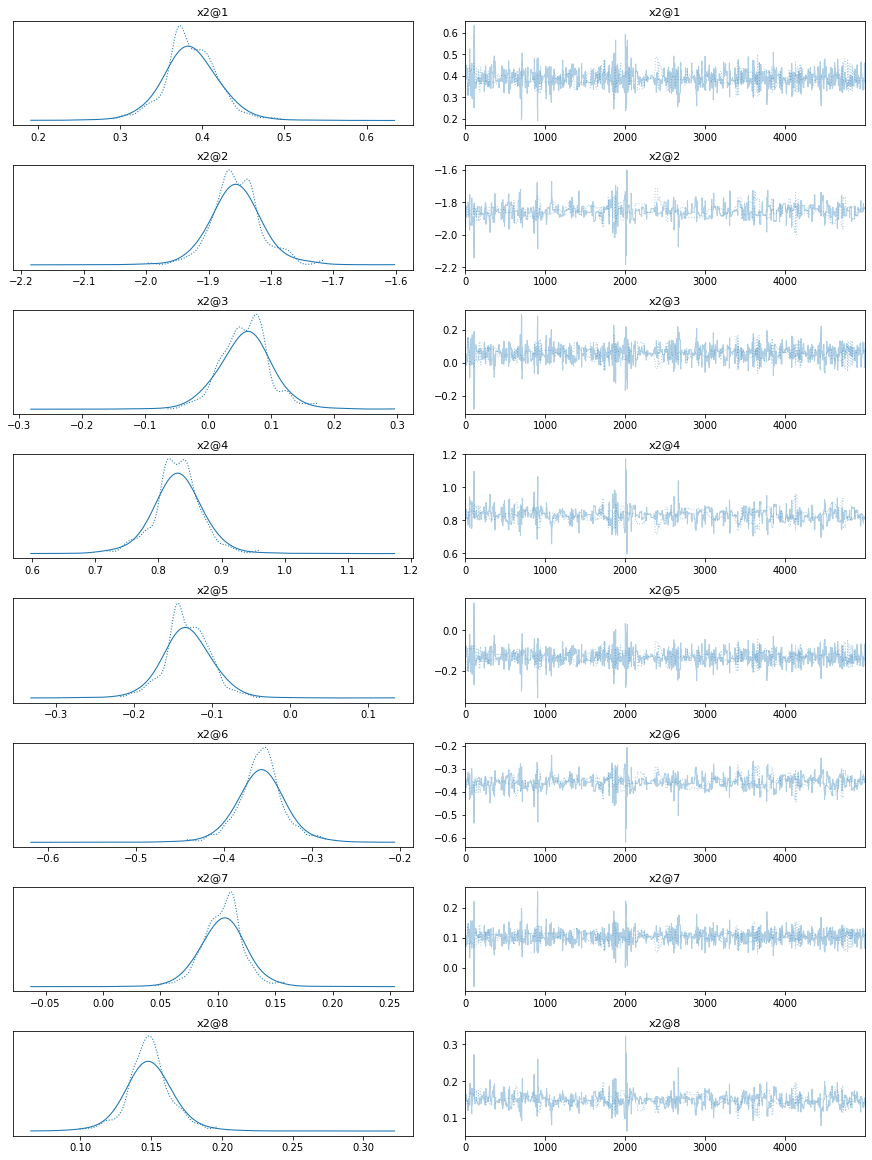

In [13]:
# Plot Output Posterior Distributions
with Model2:
    trarr = pm.traceplot(trace2, varnames=['x2@1','x2@2','x2@3','x2@4', 'x2@5','x2@6','x2@7','x2@8'], 
                  lines={'x2@1': xData[1], 'x2@2': xData[2], 'x2@3': xData[3], 'x2@4': xData[4], 'x2@5': xData[5], 'x2@6': xData[6], 'x2@7': xData[7], 'x2@8': xData[8]} );
    plt.savefig('Case3_Model2_OutputPosts', format='eps')
    plt.show()

##############################################################################################################
### Case 3.3: Reconstructing $k$ and $c$ from the Noisy Data
### Note: $\sigma_L$ gets Calibrated as well

In [14]:
# Model 3
Model3 = pm.Model()

# Model Construction
with Model3:
    K3     = pm.Normal('K3',    1.0, numpy.sqrt(0.5))
    c3mu   = pm.Normal('c3mu',        0.0, numpy.sqrt(0.5))
    c3sigma= pm.Lognormal('c3sigma', -1.0, numpy.sqrt(0.4))
    c3     = pm.Lognormal('c3',      c3mu, c3sigma) 
    xPred3 = th_forward_model(K3, c3)
    x3At0  = pm.Deterministic('x3@0',xPred3[0])
    x3At1  = pm.Deterministic('x3@1',xPred3[1])
    x3At2  = pm.Deterministic('x3@2',xPred3[2])
    x3At3  = pm.Deterministic('x3@3',xPred3[3])
    x3At4  = pm.Deterministic('x3@4',xPred3[4])
    x3At5  = pm.Deterministic('x3@5',xPred3[5])
    x3At6  = pm.Deterministic('x3@6',xPred3[6])
    x3At7  = pm.Deterministic('x3@7',xPred3[7])
    x3At8  = pm.Deterministic('x3@8',xPred3[8])
    Sigma3 = pm.Lognormal('Sigma3', 0.0, 1.0)
    yLike3 = pm.Normal('yLike3', mu=xPred3, sd=Sigma3, observed=xDataNoise)

# Model Calibration with Noisy Data
with Model3:
    trace3 = pm.sample(5000, step=pm.Metropolis(), tune=1000, cores=1)

/usr/local/lib/python3.8/site-packages/pymc3/sampling.py:465: FutureWarning: In an upcoming release, pm.sample will return an `arviz.InferenceData` object instead of a `MultiTrace` by default. You can pass return_inferencedata=True or return_inferencedata=False to be safe and silence this warning.
  warnings.warn(
Sequential sampling (2 chains in 1 job)
CompoundStep
>Metropolis: [Sigma3]
>Metropolis: [c3]
>Metropolis: [c3sigma]
>Metropolis: [c3mu]
>Metropolis: [K3]


Sampling 2 chains for 1_000 tune and 5_000 draw iterations (2_000 + 10_000 draws total) took 165 seconds.
The number of effective samples is smaller than 10% for some parameters.


/usr/local/lib/python3.8/site-packages/pymc3/plots/__init__.py:35: UserWarning: Keyword argument `varnames` renamed to `var_names`, and will be removed in pymc3 3.8
  warnings.warn(
/usr/local/lib/python3.8/site-packages/arviz/plots/backends/matplotlib/traceplot.py:150: UserWarning: A valid var_name should be provided, found {'S', 'K', 'c'} expected from {'K3', 'Sigma3', 'c3'}
  warnings.warn(
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; part

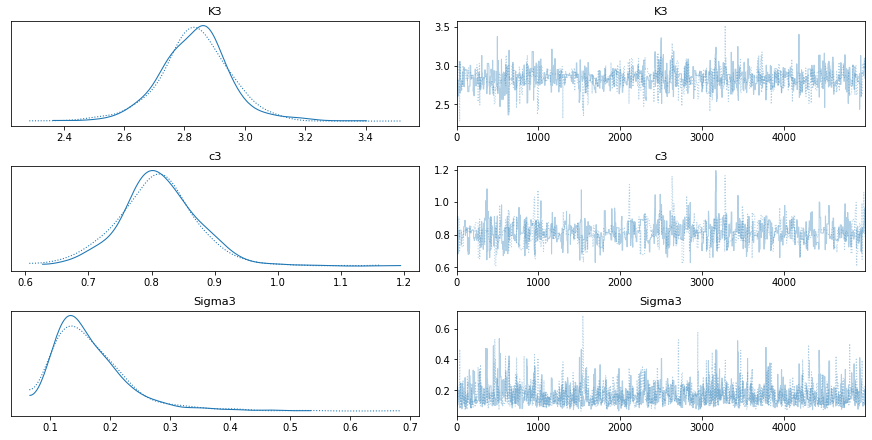

In [16]:
# Plot Parameter Posterior Distributions
with Model3:
    trarr = pm.traceplot(trace3, varnames=['K3', 'c3', 'Sigma3'], lines={'K3': 3.0, 'c3': 0.5, 'Sigma3': Sigma3});
    plt.savefig('Case3_Model3_ParamPosts', format='eps')
    plt.show()

In [17]:
# Print Statistics
with Model3:
    print(pm.summary(trace3))

          mean     sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  ess_mean   ess_sd  \
K3       2.836  0.114   2.626    3.059      0.004    0.003     723.0    723.0   
c3mu    -0.154  0.351  -0.802    0.565      0.008    0.006    1726.0   1698.0   
c3sigma  0.401  0.261   0.050    0.851      0.007    0.005    1420.0   1420.0   
c3       0.811  0.064   0.691    0.926      0.003    0.002     521.0    521.0   
x3@0     4.000  0.000   4.000    4.000      0.000    0.000   10000.0  10000.0   
x3@1     0.492  0.100   0.307    0.678      0.003    0.002    1308.0   1272.0   
x3@2    -1.818  0.109  -2.027   -1.616      0.005    0.003     550.0    543.0   
x3@3    -0.067  0.122  -0.298    0.156      0.004    0.003    1031.0    920.0   
x3@4     0.813  0.100   0.624    0.998      0.004    0.003     514.0    504.0   
x3@5    -0.037  0.089  -0.195    0.133      0.003    0.002    1056.0   1056.0   
x3@6    -0.358  0.069  -0.493   -0.235      0.003    0.002     492.0    483.0   
x3@7     0.046  0.055  -0.05

/usr/local/lib/python3.8/site-packages/pymc3/plots/__init__.py:35: UserWarning: Keyword argument `varnames` renamed to `var_names`, and will be removed in pymc3 3.8
  warnings.warn(
/usr/local/lib/python3.8/site-packages/arviz/plots/backends/matplotlib/traceplot.py:150: UserWarning: A valid var_name should be provided, found {'x'} expected from {'x3@3', 'x3@2', 'x3@6', 'x3@1', 'x3@5', 'x3@7', 'x3@8', 'x3@4'}
  warnings.warn(
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend doe

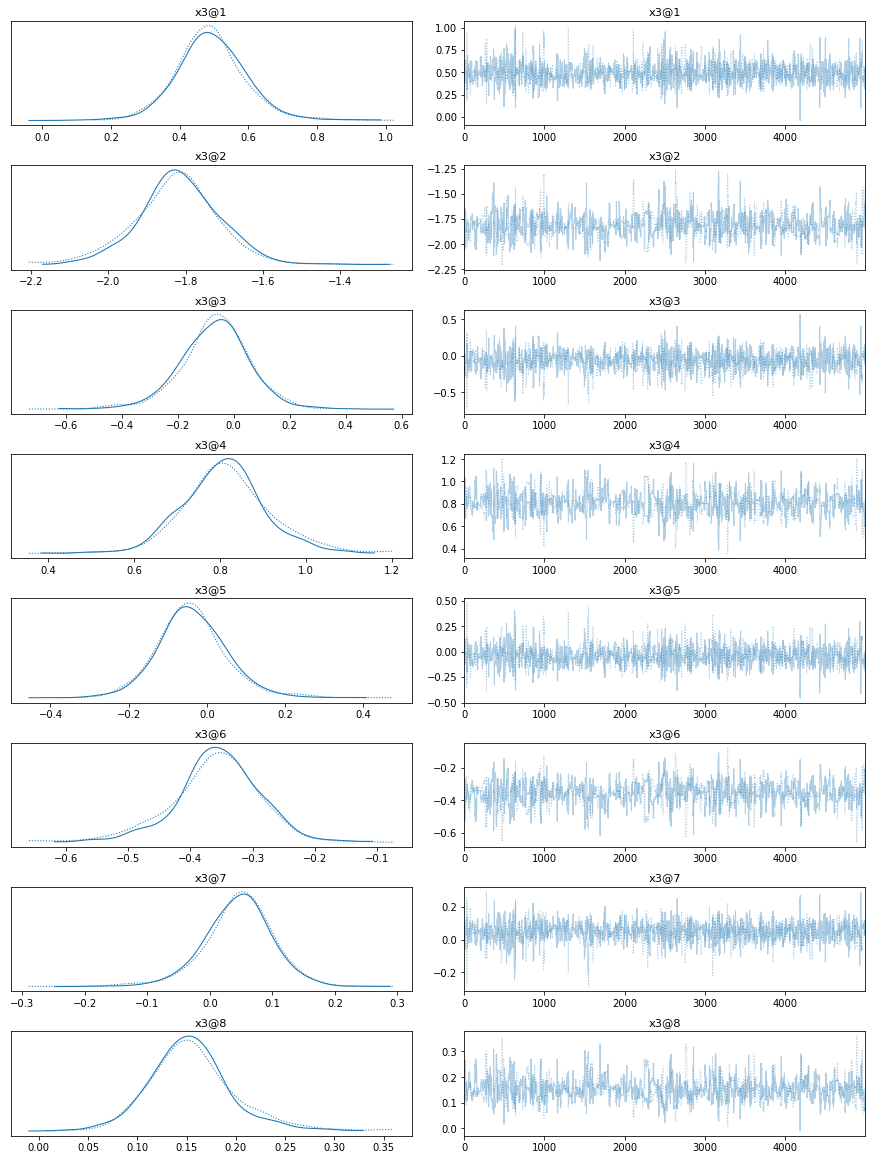

In [18]:
# Plot Output Posterior Distributions
with Model3:
    trarr = pm.traceplot(trace3, varnames=['x3@1','x3@2','x3@3','x3@4', 'x3@5','x3@6','x3@7','x3@8'], 
                  lines={'x3@1': xData[1], 'x3@2': xData[2], 'x3@3': xData[3], 'x3@4': xData[4], 'x3@5': xData[5], 'x3@6': xData[6], 'x3@7': xData[7], 'x3@8': xData[8]} );
    plt.savefig('Case3_Model3_OutputPosts', format='eps')
    plt.show()